# Practice problems 2.5

## Exercise 1

Obtain the dataset [Wine](https://archive.ics.uci.edu/dataset/109/wine), split it in training (70%) and test sets (30%).

In [1]:
!pip install -q ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wine = fetch_ucirepo(id=109) 
X = wine.data.features 
y = wine.data.targets

In [3]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Alcohol                       178 non-null    float64
 1   Malicacid                     178 non-null    float64
 2   Ash                           178 non-null    float64
 3   Alcalinity_of_ash             178 non-null    float64
 4   Magnesium                     178 non-null    int64  
 5   Total_phenols                 178 non-null    float64
 6   Flavanoids                    178 non-null    float64
 7   Nonflavanoid_phenols          178 non-null    float64
 8   Proanthocyanins               178 non-null    float64
 9   Color_intensity               178 non-null    float64
 10  Hue                           178 non-null    float64
 11  0D280_0D315_of_diluted_wines  178 non-null    float64
 12  Proline                       178 non-null    int64  
dtypes: fl

In [4]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   class   178 non-null    int64
dtypes: int64(1)
memory usage: 1.5 KB


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (124, 13)
X_test shape: (54, 13)
y_train shape: (124, 1)
y_test shape: (54, 1)


## Exercise 2

Train one decision tree classifier and calculate a confidence interval for its accuracy in the test dataset using a Binomial distribution.

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

cf = DecisionTreeClassifier(random_state=42)
cf.fit(X_train, y_train)
y_pred = cf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.95      0.95      0.95        19
           2       0.95      1.00      0.98        21
           3       1.00      0.93      0.96        14

    accuracy                           0.96        54
   macro avg       0.97      0.96      0.96        54
weighted avg       0.96      0.96      0.96        54



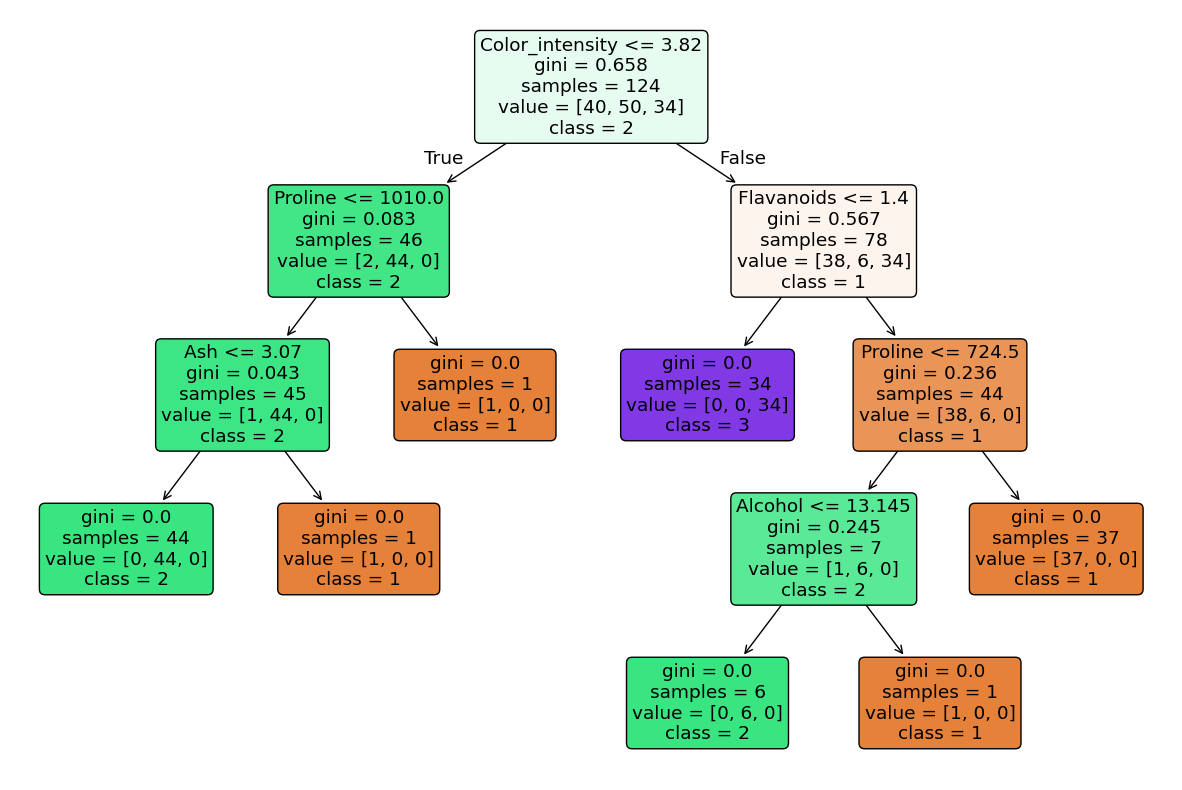

In [7]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
tree.plot_tree(cf, filled=True, feature_names=X.columns, class_names=cf.classes_.astype(str), rounded=True)
plt.show()

No we will use the normal approximation of the binomial to get the confidence interval. It says that:

$$\hat{p} \pm z_{\alpha/2} \cdot \sqrt{ \frac{\hat{p}(1 - \hat{p})}{n} }$$

In [8]:
import scipy.stats as stats
import numpy as np
from sklearn.metrics import accuracy_score

p_hat = accuracy_score(y_test, y_pred)
print(f"Accuracy: {p_hat:.4f}")
n = len(y_test)
alpha = 0.05
z = stats.norm.ppf(1 - alpha / 2)
margin = z * np.sqrt((p_hat * (1 - p_hat)) / n)
l = max(0,p_hat - margin)
u = min(p_hat + margin,1)
print(f"{int((1-alpha)*100)}% CI: ({l:.4f}, {u:.4f})")

Accuracy: 0.9630
95% CI: (0.9126, 1.0000)


## Exercise 3

Perform cross-validation with bootstrap (30 repetitions) and calculate a confidence interval for its accuracy using a Student’s t distribution.

In [9]:
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
import numpy as np

n_repetitions = 30
accuracy_scores_dt = np.zeros(n_repetitions)
cf = DecisionTreeClassifier(random_state=42)

for i in range(n_repetitions):
    X_bootstraped, y_bootstraped = resample(X_train, y_train,n_samples=200, random_state=i)
    X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(X_bootstraped, y_bootstraped,
                                                                test_size=1/np.e, random_state=i)
    cf.fit(X_b_train, y_b_train)
    y_pred = cf.predict(X_b_test)
    accuracy_scores_dt[i] = accuracy_score(y_b_test, y_pred)

print(f'Bootstrap {n_repetitions} repetitions accuracy scores for Decision Tree:\n{accuracy_scores_dt}')

Bootstrap 30 repetitions accuracy scores for Decision Tree:
[0.97297297 0.98648649 0.97297297 0.97297297 1.         0.97297297
 0.93243243 0.95945946 0.97297297 0.91891892 0.95945946 0.98648649
 0.95945946 0.98648649 0.98648649 0.94594595 1.         0.95945946
 0.94594595 0.95945946 0.91891892 0.95945946 0.89189189 0.97297297
 0.93243243 0.93243243 0.97297297 0.91891892 0.95945946 0.93243243]


In [10]:
from scipy import stats

confidence = 0.95
mean = accuracy_scores_dt.mean()
std = np.std(accuracy_scores_dt, ddof=1)
sem = std / np.sqrt(n_repetitions)
degrees = n_repetitions - 1

l,r = stats.t.interval(confidence, degrees, loc=mean, scale=sem)
print(f"Mean Accuracy scores: {mean:.3f}")
print(f"{int(confidence*100)}% CI: ({l:.4f}, {r:.4f})")

Mean Accuracy scores: 0.958
95% CI: (0.9482, 0.9680)


## Exercise 4

Consider an additional random forest classifier and compare its performance with the decision
tree classifier using cross-validation (30 repetitions) with bootstrap and a t-test.

In [11]:
from sklearn.ensemble import RandomForestClassifier

cf = RandomForestClassifier(random_state=42)
accuracy_scores_rf = np.zeros(n_repetitions)

for i in range(n_repetitions):
    X_bootstraped, y_bootstraped = resample(X_train.values, y_train.values.flatten(),n_samples=200, random_state=i)
    X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(X_bootstraped, y_bootstraped,
                                                                test_size=1/np.e, random_state=i)
    cf.fit(X_b_train, y_b_train.flatten())
    y_pred = cf.predict(X_b_test)
    accuracy_scores_rf[i] = accuracy_score(y_b_test, y_pred)

print(f'Bootstrap {n_repetitions} repetitions accuracy scores for Random Forest:\n{accuracy_scores_rf}')

Bootstrap 30 repetitions accuracy scores for Random Forest:
[0.98648649 0.97297297 1.         0.98648649 1.         0.97297297
 0.97297297 0.97297297 0.98648649 0.95945946 1.         1.
 1.         1.         0.98648649 0.97297297 1.         1.
 0.98648649 0.97297297 0.97297297 0.98648649 0.98648649 1.
 1.         0.98648649 1.         1.         0.97297297 0.97297297]


Now we will design the t-test. We will begin with the null hypothesis ($H_0$) and the alternative hypothesis ($H_1$).

As we want to compare the accuracy of the models, we will say that $a_{D}$ is the accuracy of the decision tree classifier and $a_{F}$ is the accuracy of the random forest classifier. Then, after the bootstrap exercise of the two models, we have the estimators $\hat{a_{D}}$ and $\hat{a_{F}}$, which came from both bootstrap exercises we did with $N$ experiments.

Taking this into account, our hypothesis will be:

$$
\begin{align*}
    H_0 & : & a_{F} - a_{D} = 0 & \Longleftrightarrow & \text{Both models have the same performance} \\
    H_1 & : & a_{F} - a_{D} \neq 0 & \Longleftrightarrow & \text{Models have different performance}
\end{align*}
$$

As we don't know $\sigma_{D}$ or $\sigma_{F}$ we will apply a t-test. In this scenario, we will calculate the $s$ statistic for the difference between the accuracies per experiment:

$$m = \hat{a}_F - \hat{a}_D$$

$$s^2_{DF} = \dfrac{\sum_{i=1}^{N} (a_{F}^{i} - a_{D}^{i} - m)^2}{N-1}$$


The degrees of freedom are $2N - 2$ because we estimate two means from $2N$ independent samples. Now, given a $\alpha$ level of significance, we can apply our t-test checking that:

$$
t = \frac{\sqrt{N} (\hat{a}_F - \hat{a}_D)}{s_{DF}} \quad \text{and we reject } H_0 \text{ if } |t| > t_{\alpha/2,\, 2N - 2} \Longleftrightarrow t \notin \left( - t_{\alpha/2,\, 2N - 2} , t_{\alpha/2,\, 2N - 2}   \right) 
$$

In [12]:
import scipy.stats as stats
import numpy as np

#Manual calculation

#For decision tree
a_d_hat = accuracy_scores_dt.mean()
print(f"Mean Accuracy for decission tree: {a_d_hat:.3f}")
#For random forest
a_f_hat = accuracy_scores_rf.mean()
print(f"Mean Accuracy for random forest: {a_f_hat:.3f}\n")
#t-stat
m = a_f_hat - a_d_hat
n = len(accuracy_scores_rf)
dif = accuracy_scores_rf - accuracy_scores_dt
s_df = np.sqrt(np.var(dif, ddof=1))
t = np.sqrt(n) * m/s_df

#Scipy calculation
t_stat, p_value = stats.ttest_rel(accuracy_scores_rf, accuracy_scores_dt)
assert np.isclose(t_stat, t), "t-statistics do not match!"

significance_level = 0.05
df = 2*len(accuracy_scores_dt) - 2
t_critical = stats.t.ppf(1 - significance_level/2, df)
reject_manual = abs(t) > t_critical
reject_scipy = p_value < significance_level

assert reject_manual == reject_scipy, "Reject decision does not match!"

if reject_manual:
    print(f"Reject null hypothesis --> a_f ≠ a_d")
else:
    print(f"Do not reject null hypothesis --> a_f = a_d")

Mean Accuracy for decission tree: 0.958
Mean Accuracy for random forest: 0.987

Reject null hypothesis --> a_f ≠ a_d


As we can see, we have enough statistical support to say that the decission tree classifier and the random forest classifier have different performances; and by checking the estimator, we can say that random forest has a better performance (This final statement is not fully supported by the test, in order to give a fairly supported statement, we must do a one-tail t-test which will be left as a future excercise).

## Exercise 5

Compare the two classifiers using McNeamar’s test.

In [13]:
import scipy.stats as stats
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np

rf = RandomForestClassifier(random_state=42).fit(X_train, y_train.values.flatten())
dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train.values.flatten())

y_pred_rf = rf.predict(X_test)
y_pred_dt = dt.predict(X_test)
y_test_ = y_test.values.flatten()

e00 = np.sum((y_pred_rf != y_test_) & (y_pred_dt != y_test_))
e01 = np.sum((y_pred_rf != y_test_) & (y_pred_dt == y_test_))
e10 = np.sum((y_pred_rf == y_test_) & (y_pred_dt != y_test_))
e11 = np.sum((y_pred_rf == y_test_) & (y_pred_dt == y_test_))
print(f"e00: {e00}, e01: {e01}, e10: {e10}, e11: {e11}")

table = np.array([[e00, e01], [e10, e11]])

#Mcneamar test manual calculation
stat = (abs(e01 - e10)-1)**2 / (e01 + e10)

significance_level = 0.05
chi_squred = stats.chi2.ppf(1-significance_level, 1)
reject_manual = stat > chi_squred

#Mcneamar test scipy calculation
result = mcnemar(table, exact=False, correction=True)
reject_scipy = result.pvalue < significance_level

#Retrieve result
assert np.isclose(result.statistic,stat), "Mcnemar test statistic do not match!"
assert reject_manual == reject_scipy, "Mcnemar test reject do not match!"

print(f"Stat: {stat}")

if reject_manual:
    print(f"Reject null hypothesis --> e_f ≠ e_d")
else:
    print(f"Do not reject null hypothesis --> e_f = e_d")

e00: 0, e01: 0, e10: 2, e11: 52
Stat: 0.5
Do not reject null hypothesis --> e_f = e_d


In this case, the test tell us that the performance of the models is meaningfuly the same.